In [1]:
# For Google Colab Use
COLAB = False
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Coding/Projects/MarketMakingAgents/market-making-agents'
    #!git fetch origin
    #!git reset --hard origin/master
    #!git pull
    #!git checkout .

In [2]:
if COLAB:
    %load_ext tensorboard
    %tensorboard --logdir runs

    %reload_ext tensorboard
    # Note you can inspect the tensorboard and get url to open in new tab

# Clear any logs from previous runs
!rm -rf ./runs/

In [3]:
from Source.StockExchange import StockExchange
from Source.DealerEnvironment import DealerEnvironment

from Source.Agents.BaselineAgents import RandomAgent, RecycleAgent, ImprovedRecycleAgent
from Source.Agents.DeepQNetwork import DQNMarketMaker
from Source.Agents.Utils.DataPlotter import DataPlotter

import numpy as np
import matplotlib.pyplot as plt

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer1 = SummaryWriter(flush_secs=15, comment='_dqnAgent')
writer3 = SummaryWriter(flush_secs=15, comment='_recycleAgent')

In [5]:
TOTAL_STEPS = 5000
TOTAL_EPISODES = 200

DQN_ACTION_SPACE = [-1.0, -0.5, 0.0, 0.5, 1.0]
STATE_SPACE_SIZE = 1

In [6]:
stockExchange = StockExchange(TOTAL_STEPS)

dealerEnv1 = DealerEnvironment(dealerId="dealer1", exchange=stockExchange)
dealerEnv3 = DealerEnvironment(dealerId="dealer3", exchange=stockExchange)

marketMaker1 = DQNMarketMaker(DQN_ACTION_SPACE, STATE_SPACE_SIZE)
marketMaker3 = ImprovedRecycleAgent()

DQN using cpu
/Users/chris/Applications/anaconda3/envs/cbenv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Skew recycling metric:

skew * 10 + inventory

aim: this should be close to 0 always. Ie:

    if inventory == 10:

        Own a lot -> need to sell -> show low offer -> negative skew (-1)
        
    if inventory == -10:

        short a lot -> need to buy -> show high bid -> positive skew (+1)
        
Good score : 0

Bad Score : +- 10

Very bad: +- 20

Also:
- Can add a 'capital charge' -> ie each step holding inventory (positive or negative) incurs a penalty reward


In [7]:
for episodeNumber in range(TOTAL_EPISODES):
    stockExchange.reset()
    state1 = dealerEnv1.reset()
    state3 = dealerEnv3.reset()

    dealer1Return = 0.0
    dealer3Return = 0.0

    dealer1Inventory = [state1.inventory]
    dealer3Inventory = [state3.inventory]

    while stockExchange.isEpisodeLive():

        skewAction1, skewActionIndex1 = marketMaker1.getSkewAction(state1)
        skewAction3 = marketMaker3.getSkewAction(state3)

        dealerEnv1.submitSkewToExchange(skewAction1)
        dealerEnv3.submitSkewToExchange(skewAction3)

        stockExchange.step()

        nextState1, reward1, done1, _ = dealerEnv1.step()
        nextState3, reward3, done3, _ = dealerEnv3.step()

        marketMaker1.inputPostTrade(state1, skewActionIndex1, reward1, done1, nextState1)

        state1 = nextState1
        state3 = nextState3
        
        dealer1Return += reward1
        dealer3Return += reward3

        dealer1Inventory.append(state1.inventory)
        dealer3Inventory.append(state3.inventory)

    # End of episode:
    writer1.add_scalar("return", dealer1Return, episodeNumber)
    writer3.add_scalar("return", dealer3Return, episodeNumber)

    writer1.add_scalar("inventory", np.mean(dealer1Inventory), episodeNumber)
    writer3.add_scalar("inventory", np.mean(dealer3Inventory), episodeNumber)

    print("Episode: {} DQN Return: {} Recycle Return: {}".format(episodeNumber, dealer1Return, dealer3Return))


Episode: 0 DQN Return: 40.94185996673664 Recycle Return: 299.96673599799607
Episode: 1 DQN Return: -194.55853593628862 Recycle Return: 50.56767892496382
Episode: 2 DQN Return: 106.33676809101986 Recycle Return: 186.38589633324227
Episode: 3 DQN Return: 215.7356266368238 Recycle Return: 118.34673540302416
Episode: 4 DQN Return: 54.95578955396862 Recycle Return: 52.95171760652681
Episode: 5 DQN Return: -62.3045376827679 Recycle Return: 160.72225965496676


KeyboardInterrupt: 

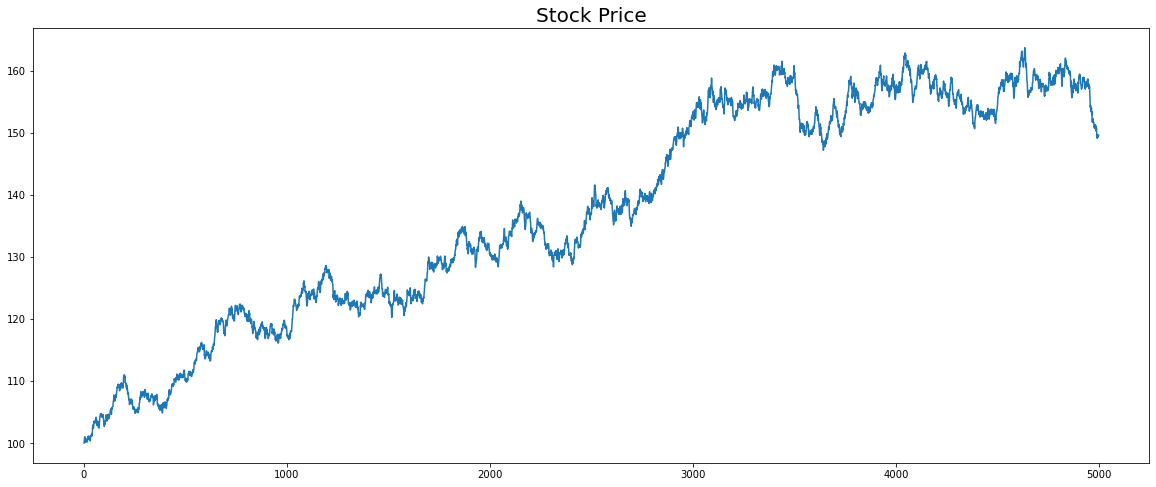

In [5]:
plt.figure(figsize=(20,8))
plt.plot(stockExchange._stockPriceProcess._priceProcess)
plt.title("Stock Price", size=20)
plt.show()

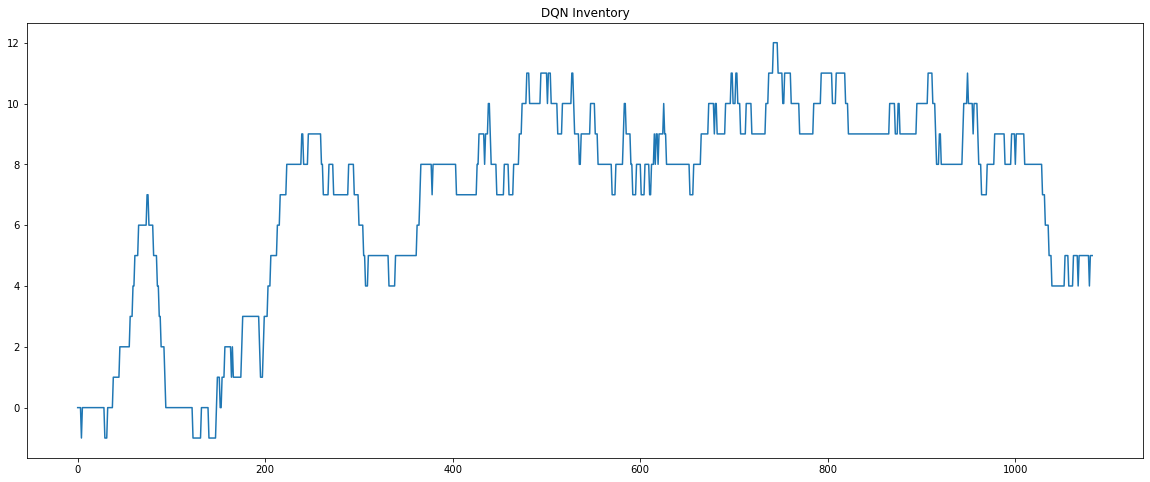

In [9]:
plt.figure(figsize=(20,8))
plt.plot(dealer1Inventory)
plt.title("DQN Inventory")
plt.show()